<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/experimental3/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# start

In [1]:
# installs

In [36]:
# imports
import tensorflow as tf
from keras.utils import plot_model
from keras.models import model_from_json
from keras import backend as K
import cv2
from google.colab.patches import cv2_imshow
import glob
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
from xml.etree.ElementTree import ElementTree as ET
from PIL import Image

In [3]:
# loading dataset
# AIZOOTech Dataset

!gdown --id 1QspxOJMDf_rAWVV7AU_Nc0rjo1_EPEDW #loading the dataset from google drive link to colab
!unzip /content/FaceMaskDataset.zip &> /dev/null #unzipping
!rm -rf /content/FaceMaskDataset.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1QspxOJMDf_rAWVV7AU_Nc0rjo1_EPEDW
To: /content/FaceMaskDataset.zip
800MB [00:10, 77.9MB/s]


In [ ]:
# hyper parameters
EPOCHS = 10
BATCH_SIZE = 16

In [109]:
# finding the perfect crop size, for whole dataset
# https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-to-get-image-size
  
train_dir_path = "/content/train"
val_dir_path = "/content/val"

train_xml_paths = glob.glob(train_dir_path + '/**/*.xml', recursive=True)
val_xml_paths = glob.glob(val_dir_path + '/**/*.xml', recursive=True)

print("length of train images, ", len(train_xml_paths)) #output: 6132
print("length of val images", len(val_xml_paths))   #output: 1839
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CHANNELS = 3

# shuffling data
np.random.shuffle(train_xml_paths)
np.random.shuffle(val_xml_paths)

# creating TrainX and TrainY
TrainX = []
TrainY = []
with_mask = np.zeros(shape=(2,)); with_mask[1] = 1       #class: 1
without_mask = np.zeros(shape=(2,)); without_mask[0] = 1 #class: 0
idx = 0
for path in train_xml_paths:
  tree = ET()
  root = tree.parse(path)
  filename = root.findall('filename')[0].text
  names = [f.text for f in root.findall('.//name')]
  xmins = [int(f.text) for f in root.findall('.//xmin')]
  ymins = [int(f.text) for f in root.findall('.//ymin')]
  xmaxs = [int(f.text) for f in root.findall('.//xmax')]
  ymaxs = [int(f.text) for f in root.findall('.//ymax')]
  if filename[-3:] == "xml":
    filename = filename[:-3]+"jpg"
  img = Image.open(train_dir_path + "/" + filename).convert('RGB')
  for j in range(len(names)):
    cropped_img = img.crop((xmins[j], ymins[j], xmaxs[j], ymaxs[j]))
    resized_img = cropped_img.resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.LANCZOS)
    arr = np.asarray(resized_img)
    TrainX.append(arr)
    if names[j]=='face':
      TrainY.append(without_mask)
    else:
      TrainY.append(with_mask)
    idx+=1
TrainX = np.asarray(TrainX)
TrainY = np.asarray(TrainY)
print(TrainX.shape) #output: (13593, 224, 224, 3)
print(TrainY.shape) #output: ()

length of train images,  6132
length of val images 1839
(13593, 224, 224, 3)
(13593, 2)


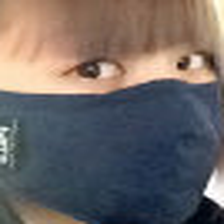

[0. 1.]


In [118]:
#random train observations

rnd_idx = np.random.randint(0, TRAIN_DATA_SIZE)
display(Image.fromarray(np.uint8(TrainX[rnd_idx])))
print(TrainY[rnd_idx])
# with mask is [0. 1.]
# without mask is [1. 0.]

In [ ]:
# Model(Transfer Learning) (Later)

In [ ]:
# Adding call Back Functions
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Main Model 

class MModel:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.model = self.get_model()
    self.train_history = []
    self.val_history = []
    self.test_history = []


  def get_model(self):
    inputs = tf.keras.Input(shape=self.input_shape)  #input layer
    base_model = tf.keras.applications.Xception(
                weights='imagenet',
                input_shape=self.input_shape,
                include_top=False)(inputs)
    layer1 = tf.keras.layers.Conv2D(
        filters=2,
        kernel_size=4,
        strides=(1, 1),
        padding="valid",
        data_format=None,
        dilation_rate=(1, 1),
        groups=1,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(base_model)
    batch_normalization_layer1 = tf.keras.layers.BatchNormalization()(layer1)
    max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid')(batch_normalization_layer1)
    drop_out_layer1 = tf.keras.layers.Dropout(rate=0.1)(max_pool_2d)
    layer2 = tf.keras.layers.Flatten()(drop_out_layer1)
    batch_normalization_layer2 = tf.keras.layers.BatchNormalization()(layer2)
    Dense_layer1 = tf.keras.layers.Dense(
        84,
        activation='relu',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(batch_normalization_layer2)
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
    )(Dense_layer1)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.summary()
    plot_model(model, to_file='main_model_V040301.png') #convention for the model plot: main_model_VddMMXX where XX is the model number
    return model

  def compile(self, optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def train(self, train_dataset, epochs=1):
    self.train_history = self.model.fit(train_dataset, validation_data = val_dataset, epochs=epochs, verbose=1)

  def evaluate(self, val_dataset, batch_size="32"):
    self.val_history = self.model.evaluate(val_dataset, batch_size=32, verbose=1)

  def predict_single(self, image):
    """
      image dimensions should be (153, 153, 3)
    """
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    p = self.model.predict(input_arr, verbose = 0)
    return round(p[0][0])

  def plot_loss_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[0])
    plt.plot(list(self.train_history.history.values())[4])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_accuracy_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[1])
    plt.plot(list(self.train_history.history.values())[5])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_f1_per_epoch(self):
    plt.plot(self.train_history.history['f1'])
    plt.title('model f1_score')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
  
  def plot_precision_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[2])
    plt.plot(list(self.train_history.history.values())[6])
    plt.title('model precision_score')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_recall_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[3])
    plt.plot(list(self.train_history.history.values())[7])
    plt.title('model recall_score')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def write_model_with_weights_to_file(self, filepath):
    self.model.save(filepath)

In [ ]:
# Creating instance of MModel Class

mmodel = MModel((153, 153, 3))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 153, 153, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 2)           65538     
_________________________________________________________________
batch_normalization_10 (Batc (None, 2, 2, 2)           8         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 2)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0   

In [ ]:
# Model Compilation
# https://keras.io/api/models/model_training_apis/

mmodel.compile()

In [ ]:
# Training
# https://keras.io/api/models/model_training_apis/

mmodel.train(train_dataset, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 120s 186ms/step - loss: 0.2321 - acc: 0.9617 - precision_1: 0.9751 - recall_1: 0.9446 - val_loss: 0.0940 - val_acc: 0.9725 - val_precision_1: 0.9479 - val_recall_1: 1.0000
Epoch 2/10
625/625 [==============================] - 115s 184ms/step - loss: 0.0337 - acc: 0.9902 - precision_1: 0.9919 - recall_1: 0.9883 - val_loss: 0.0175 - val_acc: 0.9950 - val_precision_1: 0.9975 - val_recall_1: 0.9925
Epoch 3/10
625/625 [==============================] - 115s 184ms/step - loss: 0.0196 - acc: 0.9941 - precision_1: 0.9937 - recall_1: 0.9945 - val_loss: 0.0125 - val_acc: 0.9975 - val_precision_1: 0.9975 - val_recall_1: 0.9975
Epoch 4/10
625/625 [==============================] - 115s 184ms/step - loss: 0.0216 - acc: 0.9929 - precision_1: 0.9927 - recall_1: 0.9931 - val_loss: 0.0173 - val_acc: 0.9975 - val_precision_1: 1.0000 - val_recall_1: 0.9950
Epoch 5/10
625/625 [==============================] - 115s 183ms/step - loss: 0.0157 - acc: 0.99

In [ ]:
# model evaluation on val dataset
# https://keras.io/api/models/model_training_apis/

mmodel.evaluate(val_dataset)

50/50 [==============================] - 3s 55ms/step - loss: 0.0248 - acc: 0.9925 - precision_1: 0.9852 - recall_1: 1.0000


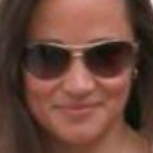

Ground Truth 1.0
Prediction 1


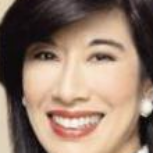

Ground Truth 1.0
Prediction 1


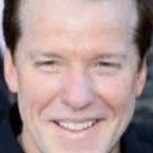

Ground Truth 1.0
Prediction 1


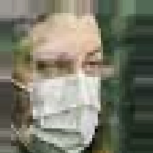

Ground Truth 0.0
Prediction 0


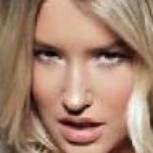

Ground Truth 1.0
Prediction 1


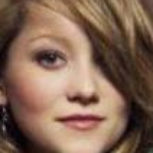

Ground Truth 1.0
Prediction 1


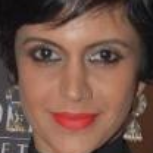

Ground Truth 1.0
Prediction 1


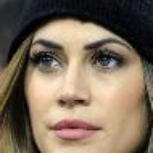

Ground Truth 1.0
Prediction 1


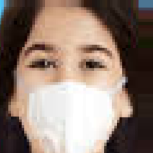

Ground Truth 0.0
Prediction 0


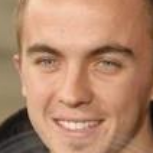

Ground Truth 1.0
Prediction 1


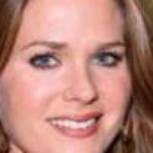

Ground Truth 1.0
Prediction 1


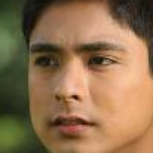

Ground Truth 1.0
Prediction 1


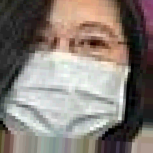

Ground Truth 0.0
Prediction 0


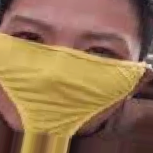

Ground Truth 0.0
Prediction 0


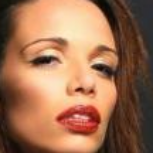

Ground Truth 1.0
Prediction 1


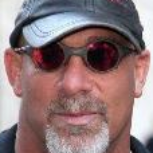

Ground Truth 1.0
Prediction 1


In [ ]:
# Predictions of Validation data set(Dev) - visualisation

i = 0
for batch in val_dataset:
  for i in range(batch_size):
    rgb_image = batch[0][i]
    label = batch[1][i].numpy()[0]

    bgr_image = cv2.cvtColor(rgb_image.numpy(), cv2.COLOR_RGB2BGR)
    cv2_imshow(bgr_image)

    print("Ground Truth", label)
    print("Prediction", mmodel.predict_single(rgb_image))
    i+=1
  if i>=10:
    break

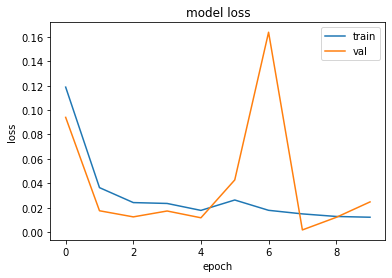

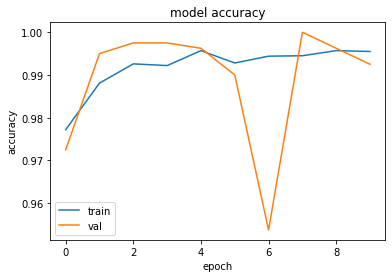

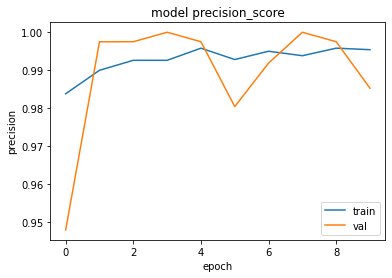

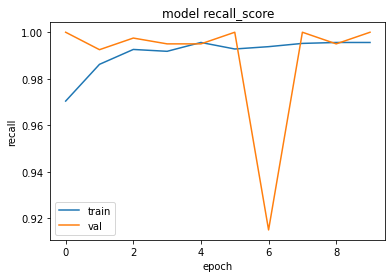

In [ ]:
# Drawing the train Loss, accuracy, f1, precision, recall of the model - visualising

mmodel.plot_loss_per_epoch()
mmodel.plot_accuracy_per_epoch()
# mmodel.plot_f1_per_epoch()
mmodel.plot_precision_per_epoch()
mmodel.plot_recall_per_epoch()

In [ ]:
# saving model to file

mmodel.write_model_with_weights_to_file('model0.h5')